# Pipeline

In [1]:
from darts import TimeSeries
from datetime import datetime

from dateutil.parser import parse
from matplotlib.pylab import rcParams
from tqdm import tqdm_notebook as tqdm
from statsmodels.tsa.stattools import adfuller
from torch.utils.tensorboard import SummaryWriter
from darts.utils.statistics import check_seasonality, plot_acf

import os
import torch
import shutil
import warnings
import itertools
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import statsmodels.api as sm
from darts.metrics import mape
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf


%matplotlib inline
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
rcParams['figure.figsize'] = 15, 5

### 1. Data Load

- TAG와 상관관계가 낮은 MELT_WEIGHT의 경우 제거

In [2]:
df = pd.read_csv('./public/data/raw_data.csv')

df['TAG'] = df['TAG'] == 'NG'

df.index = pd.date_range(start='3/4/2020', end='5/1/2020', freq='6S')[:-1]

df.drop(columns='STD_DT', inplace=True)
df.drop(columns='NUM', inplace=True)
df.drop(columns='MELT_WEIGHT', inplace=True)

df = df.astype(np.float32)
df['TAG'] = df['TAG'].astype(bool)

df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 835200 entries, 2020-03-04 00:00:00 to 2020-04-30 23:59:54
Freq: 6S
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   MELT_TEMP   835200 non-null  float32
 1   MOTORSPEED  835200 non-null  float32
 2   INSP        835200 non-null  float32
 3   TAG         835200 non-null  bool   
dtypes: bool(1), float32(3)
memory usage: 16.7 MB


,MELT_TEMP,MOTORSPEED,INSP
count,835200.000000,835200.000000,835200.000000
mean,509.200714,459.783020,3.194854
std,128.277512,639.436401,0.011822
min,308.000000,0.000000,3.170000
25%,430.000000,119.000000,3.190000
50%,469.000000,168.000000,3.190000
75%,502.000000,218.000000,3.200000
max,832.000000,1804.000000,3.230000


### 2. Data 분리

- Base 모델 학습 시 3월 달의 데이터만 사용

In [3]:
index = df.index.month == 3

train_df = df[index]
real_time_df = df[~index]

### 3. 2-stage AD의 첫번째 Stage인 PCA 훈련

In [4]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

x = train_df.drop(['TAG'], axis=1).values
y = train_df['TAG'].values
pca_scaler = StandardScaler()
x = pca_scaler.fit_transform(x)

pca = PCA(n_components=2)
printcipal_components = pca.fit_transform(x)
principal_df = pd.DataFrame(
    data=printcipal_components,
    columns=['pc1', 'pc2']
) 
principal_df['TAG'] = y

,pc1,pc2,TAG


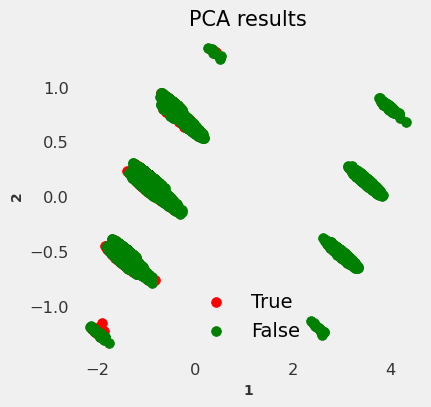

In [5]:
fig = plt.figure(figsize = (4, 4))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('1', fontsize = 10)
ax.set_ylabel('2', fontsize = 10)
ax.set_title('PCA results', fontsize=15)

targets = [True, False]
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = principal_df['TAG'] == target
    ax.scatter(
        principal_df.loc[indicesToKeep, 'pc1'],
        principal_df.loc[indicesToKeep, 'pc2'],
        c = color,
        s = 50
    )
ax.legend(targets)
ax.grid()

principal_df[(principal_df['pc1'] >= 0.5) & (principal_df['TAG'] == True)]

### 4. Base 모델 학습 (3월달 데이터로만 학습)

In [6]:
from darts.dataprocessing.transformers import Scaler
from sklearn.preprocessing import MinMaxScaler

scaler = Scaler(scaler=MinMaxScaler())

train_x_df = train_df.copy(False)

train_x_df = train_x_df[train_x_df['TAG'] == False]
train_y_df = pd.DataFrame(train_x_df.pop('TAG'), columns=['TAG'])
real_time_x_df = real_time_df.copy(False)
real_time_y_df = pd.DataFrame(real_time_x_df.pop('TAG'), columns=['TAG'])

train_x_series = TimeSeries.from_dataframe(train_x_df, freq='6S', fill_missing_dates=True)
train_y_series = TimeSeries.from_dataframe(train_y_df, freq='6S', fill_missing_dates=True)
real_time_x_series = TimeSeries.from_dataframe(real_time_x_df, freq='6S', fill_missing_dates=True)
real_time_y_series = TimeSeries.from_dataframe(real_time_y_df, freq='6S', fill_missing_dates=True)

train_scaled = scaler.fit_transform(train_x_series)
real_time_scaled = scaler.transform(real_time_x_series)

train_scaled = train_scaled.astype(np.float32)
real_time_scaled = real_time_scaled.astype(np.float32)

total_scaled = scaler.fit_transform(TimeSeries.from_dataframe(df.drop(columns=['TAG']), freq='6S', fill_missing_dates=True)).astype(np.float32)

In [10]:
from darts.models import TransformerModel

ensemble_models = [
    TransformerModel(
        input_chunk_length=30,
        output_chunk_length=1,
        batch_size=512,
        dropout=0.1,
        model_name='transformer',
        activation="relu",
        random_state=42,
        pl_trainer_kwargs={
            "accelerator": "gpu",
            "devices": [4]
        }
    ),
    # 모델 추가
]

for i, model in enumerate(ensemble_models):
    ensemble_models[i] = model.load(f'./models/{model.model_name}/{model.model_name}.pt')

### 5. 실시간 추론

In [11]:
six_sec_size = 1
min_size = 10
hour_size = min_size * 60
day_size = hour_size * 24

# 4월 1일 첫 한 시간

for model in ensemble_models:
    pred = model.predict(n=1, series=(total_scaled[train_scaled.time_index])[-30:], verbose=False)
    pred = scaler.inverse_transform(pred)[0].values()
    
MSE_array = np.array([])
GT_list = []

size = six_sec_size
for i in range(0, len(real_time_scaled) // size):
    x = real_time_scaled[i * size : (i+1) * size]
    inversed_x = scaler.inverse_transform(x).values()
    gt = real_time_y_series[i].values().squeeze() == 1
    
    MSE = (pred - inversed_x)  ** 2
    
    pca_normal = pca.transform(pca_scaler.transform(inversed_x)).squeeze()[0] >= 0.5
    if not pca_normal:
        if len(MSE_array) == 0:
            MSE_array = [MSE]
        else:
            MSE_array = np.concatenate([MSE_array, [MSE]], axis=1)
        GT_list.append(gt)
    

    

    for model in ensemble_models:
        prev = x[0].time_index[-1]
        pred = model.predict(n=size, series=(total_scaled[: prev])[-30:], verbose=False)
        pred = scaler.inverse_transform(pred)[0].values()

    if i > 300:
        break

2022-11-07 09:17:40 pytorch_lightning.utilities.distributed INFO: GPU available: True, used: True
2022-11-07 09:17:40 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-11-07 09:17:40 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
2022-11-07 09:17:40 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
2022-11-07 09:17:43 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
2022-11-07 09:17:43 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
2022-11-07 09:17:43 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
2022-11-07 09:17:43 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
2022-11-07 09:17:43 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,

In [12]:
MSE_df = pd.DataFrame(MSE_array.squeeze(), columns=['MELT_TEMP', 'MOTORSPEED', 'INSP'])

MSE_df['anomaly'] = GT_list

MSE_df

,MELT_TEMP,MOTORSPEED,INSP,anomaly
0,0.525855,1141.053223,0.000051,False
1,290.899841,2373.165039,0.000001,True
2,5.233662,5.627514,0.000001,False
3,51.622875,24.028934,0.000024,True
4,282.868500,5.224241,0.000024,True
...,...,...,...,...
237,217.485077,60.227699,0.000006,False
238,288.925293,8.602973,0.000085,True
239,300.083099,8.151785,0.000020,False
240,702.945679,175.692932,0.000018,True


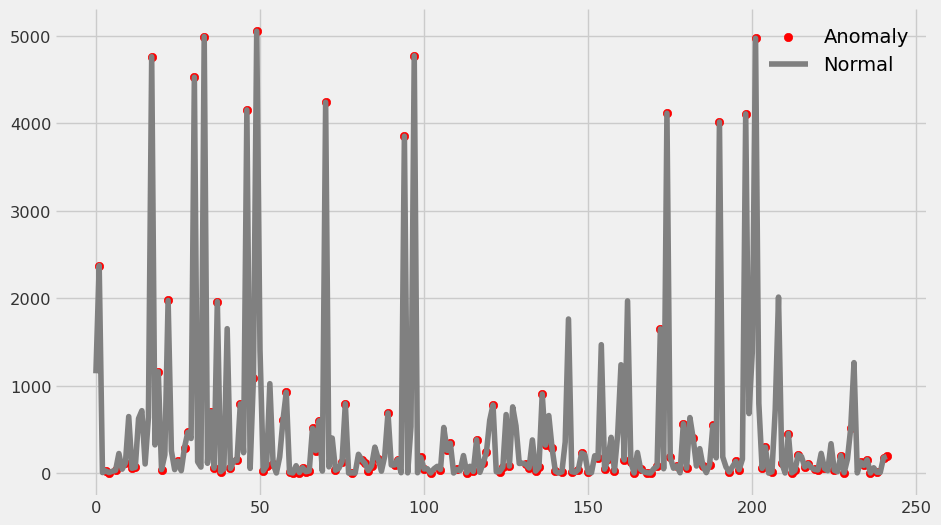

In [14]:
col = 'MOTORSPEED'

fig, ax = plt.subplots(figsize=(10, 6))

a = MSE_df.loc[MSE_df['anomaly'] == True, [col]]
ax.scatter(a.index, a[col], color='red', label='Anomaly')
ax.plot(MSE_df.index, MSE_df[col], color='grey', label='Normal')

plt.legend()
plt.show()

In [214]:
# MSE_df.loc[(MSE_df['MELT_TEMP'] < 100) & (MSE_df['anomaly'] == True)]

MSE_df.loc[(MSE_df['MELT_TEMP'] < 50)]
# MSE_df.loc[(MSE_df['anomaly'] == True)]

,MELT_TEMP,MOTORSPEED,INSP,anomaly
9,30.049589,2453.178955,2.055240e-06,True
37,25.467560,4128.615234,1.429837e-07,True
44,10.162880,7068.261230,3.560392e-05,True
48,0.707081,6.102564,9.740012e-08,True
60,33.110600,2167.113037,1.688702e-05,True
62,7.921834,2771.428223,1.884619e-06,True
75,26.089811,639.377686,3.047420e-05,True
76,9.939387,2384.729736,3.916867e-05,True
97,40.376858,13021.701172,2.240386e-06,True
102,19.844187,2595.801514,2.012399e-06,True
